# SGR Startup Flow: Stress Overshoot and Dynamic Noise Temperature

> **What is SGR?** The Soft Glassy Rheology (SGR) model is a **statistical mechanics framework** for materials with disordered, metastable microstructures—foams, emulsions, pastes, colloidal gels. It treats the material as mesoscopic "elements" trapped in energy wells of depth $E$, with an effective **noise temperature** $x$ providing thermal-like kicks that enable rearrangements. This trap model produces a genuine **glass transition** at $x=1$, separating solid-like and fluid-like phases.

> **Handbook:** [SGR Conventional](../../docs/source/models/sgr/sgr_conventional.rst) • [SGR Generic](../../docs/source/models/sgr/sgr_generic.rst)

## Key Physics: Stress Overshoot and Thixotropy

In **startup flow**, a constant shear rate $\dot{\gamma}$ is suddenly applied. SGR predicts the stress growth coefficient $\eta^+(t)$ with power-law transients. For $x < 1$ (glass), stress can **overshoot** before reaching steady state — a signature of thixotropic structural breakdown.

**Dynamic noise temperature** (`dynamic_x=True`): The noise temperature $x(t)$ evolves under shear via:

$$\frac{dx}{dt} = -\alpha_{\text{aging}} \cdot (x - x_{\text{eq}}) + \beta_{\text{rejuv}} \cdot \dot{\gamma} \cdot (x_{\text{ss}} - x)$$

where $x_{\text{ss}}(\dot{\gamma}) = x_{\text{eq}} + A \cdot (\dot{\gamma} \cdot \tau_0)^n$. This couples:
- **Aging**: Pulls $x$ toward equilibrium $x_{\text{eq}}$ (structural recovery)
- **Rejuvenation**: Shear pushes $x$ toward shear-rate-dependent $x_{\text{ss}}$ (breakdown)

Higher $\dot{\gamma}$ drives $x$ further from equilibrium, explaining **shear rejuvenation**. At rest, aging dominates, driving $x \to x_{\text{eq}}$.

**Phase-dependent behavior:**
- **$x < 1$** (glass): $\eta^+ \to \infty$ (no steady state without shear)
- **$x > 1$** (fluid): $\eta^+ \to \eta_0$ (zero-shear viscosity)
- **$x = 1$** (critical): Logarithmic growth

**Parameters**:
- $x$: Noise temperature — controls transient shape
- $G_0$: Elastic modulus — sets stress magnitude
- $\tau_0$: Microscopic time — sets time scale
- $x_{\text{eq}}, \alpha_{\text{aging}}, \beta_{\text{rejuv}}, A, n$: Dynamic $x$ parameters (optional)

## Learning Objectives

1. Generate synthetic startup data from calibrated SGR parameters (NB 01)
2. Fit stress growth coefficient $\eta^+(t)$ using SGRConventional
3. Explore `dynamic_x` mode for thixotropic noise temperature evolution
4. Visualize $x(t)$ trajectories under different shear rates
5. Perform Bayesian inference on startup data

## Prerequisites

- **Notebook 01**: Flow curve calibration for synthetic parameters
- Basic RheoJAX (`basic/01_quickstart.ipynb`)
- Bayesian inference (`bayesian/01_bayesian_inference.ipynb`)

## Runtime

- **Fast mode** (1 chain): ~2 min
- **Production** (4 chains): ~5 min

**Note:** SGRGeneric does NOT support startup — only SGRConventional provides startup predictions.

## 1. Setup

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import json
import os
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.sgr import SGRConventional, SGRGeneric

jax, jnp = safe_import_jax()
verify_float64()

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

## 2. Theory: SGR Startup Flow

In startup flow, a constant shear rate γ̇ is suddenly applied to a material at rest. The stress growth coefficient is:

$$
\eta^+(t) = G_0 \cdot G_0(x) \cdot \tau_0 \cdot \frac{(1 + t/\tau_0)^{x-1} - 1}{x - 1}
$$

For the special case x ≈ 1:

$$
\eta^+(t) = G_0 \cdot G_0(x) \cdot \tau_0 \cdot \ln(1 + t/\tau_0)
$$

The stress is then:

$$
\sigma(t) = \eta^+(t) \cdot \dot{\gamma}
$$

### Phase-Dependent Behavior

- **Glass (x < 1)**: η⁺ → ∞ as t → ∞ (no steady state)
- **Fluid (x > 1)**: η⁺ → η₀ (zero-shear viscosity)
- **Critical (x = 1)**: Logarithmic growth

### Dynamic Noise Temperature

With `dynamic_x=True`, the noise temperature evolves under shear:

$$
\frac{dx}{dt} = -\alpha_{\text{aging}} \cdot (x - x_{\text{eq}}) + \beta_{\text{rejuv}} \cdot \dot{\gamma} \cdot (x_{\text{ss}} - x)
$$

where:

$$
x_{\text{ss}}(\dot{\gamma}) = x_{\text{eq}} + A \cdot (\dot{\gamma} \cdot \tau_0)^n
$$

## 3. Generate Synthetic Data

Load calibrated parameters from Notebook 01 (flow curve fitting), or use default values if not available. Generate startup data at 4 shear rates with 3% Gaussian noise.

In [4]:
# Load calibrated parameters from NB 01 (or use defaults)
params_path = os.path.join("..", "outputs", "sgr", "flow_curve", "nlsq_params.json")
if os.path.exists(params_path):
    with open(params_path) as f:
        calib_params = json.load(f)
    print(f"Loaded calibrated parameters from NB 01: {calib_params}")
else:
    calib_params = {"x": 1.3, "G0": 500.0, "tau0": 1e-3}
    print(f"Using default parameters (run NB 01 first for calibrated values): {calib_params}")

# Generate clean model predictions
model_true = SGRConventional()
for name, val in calib_params.items():
    model_true.parameters.set_value(name, val)
model_true.fitted_ = True
model_true._test_mode = "startup"

gamma_dots = [0.1, 1.0, 10.0, 100.0]
t_data = np.logspace(-3, 2, 80)
rng = np.random.default_rng(42)
noise_level = 0.03

datasets = {}
for gd in gamma_dots:
    model_true._startup_gamma_dot = gd
    eta_plus_clean = np.array(model_true.predict(t_data))
    noise = 1.0 + noise_level * rng.standard_normal(len(eta_plus_clean))
    eta_plus_noisy = eta_plus_clean * noise
    eta_plus_noisy = np.maximum(eta_plus_noisy, 1e-10)  # Ensure positive
    datasets[gd] = {"t": t_data, "eta_plus": eta_plus_noisy, "eta_plus_clean": eta_plus_clean}
    print(f"γ̇={gd:6.1f}: η⁺ range [{eta_plus_noisy.min():.4g}, {eta_plus_noisy.max():.4g}] Pa·s")

Loaded calibrated parameters from NB 01: {'x': 1.0141574441977328, 'G0': 32.0972237974997, 'tau0': 256.80036392757455}
γ̇=   0.1: η⁺ range [0.02417, 2009] Pa·s
γ̇=   1.0: η⁺ range [0.02428, 1955] Pa·s
γ̇=  10.0: η⁺ range [0.02326, 1995] Pa·s
γ̇= 100.0: η⁺ range [0.02332, 1956] Pa·s


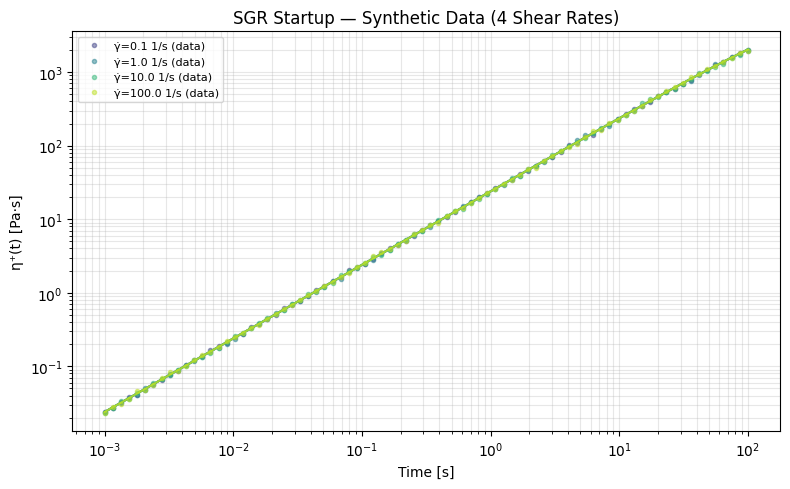

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(gamma_dots)))

for i, gd in enumerate(gamma_dots):
    d = datasets[gd]
    ax.loglog(d["t"], d["eta_plus"], "o", color=colors[i], markersize=3, alpha=0.5, label=f"γ̇={gd} 1/s (data)")
    ax.loglog(d["t"], d["eta_plus_clean"], "-", color=colors[i], lw=1.5, alpha=0.8)

ax.set_xlabel("Time [s]")
ax.set_ylabel("η⁺(t) [Pa·s]")
ax.set_title("SGR Startup — Synthetic Data (4 Shear Rates)")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

### 4.1 Single Shear Rate (γ̇ = 10 s⁻¹)

In [6]:
model = SGRConventional()

gd_fit = 10.0
d = datasets[gd_fit]

t0_fit = time.time()
model.fit(d["t"], d["eta_plus"], test_mode="startup", gamma_dot=gd_fit, method='scipy')
t_nlsq = time.time() - t0_fit

# Compute fit quality
eta_plus_pred_fit = model.predict(d["t"], test_mode="startup", gamma_dot=gd_fit)
metrics = compute_fit_quality(d["eta_plus"], eta_plus_pred_fit)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R²: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.4g} Pa·s")
print("\nFitted parameters:")
for name in ["x", "G0", "tau0"]:
    val = model.parameters.get_value(name)
    true_val = calib_params[name]
    print(f"  {name:5s} = {val:.4g}  (true: {true_val:.4g})")
print(f"Phase regime: {model.get_phase_regime()}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.557997s


INFO:nlsq.least_squares:Convergence reason=`gtol` termination condition is satisfied. | iterations=53 | final_cost=0.0319 | elapsed=1.558s | final_gradient_norm=5.1716e-08


NLSQ fit time: 1.95 s
R²: 0.999291
RMSE: 11.15 Pa·s

Fitted parameters:
  x     = 0.501  (true: 1.014)
  G0    = 26.97  (true: 32.1)
  tau0  = 341.7  (true: 256.8)
Phase regime: glass


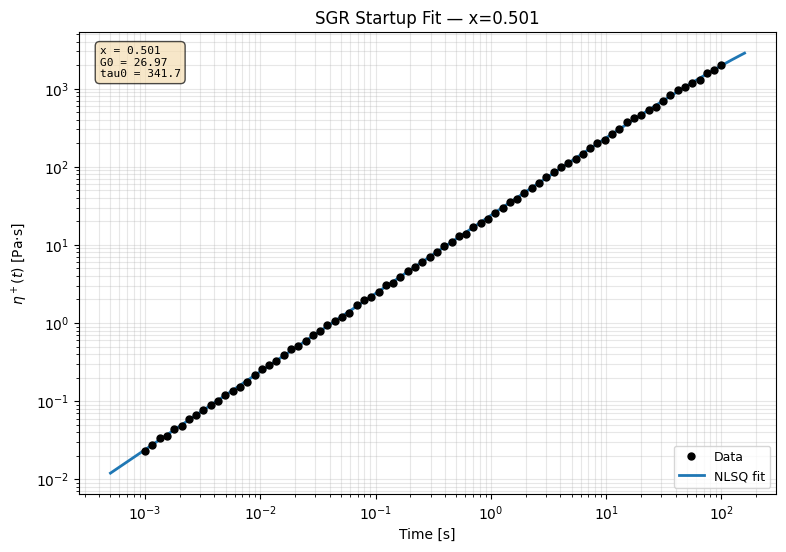

In [7]:
# Plot NLSQ fit with uncertainty band
param_names = ["x", "G0", "tau0"]
x_fit = model.parameters.get_value("x")
fig, ax = plot_nlsq_fit(
    d["t"], d["eta_plus"], model, test_mode="startup",
    param_names=param_names,
    xlabel="Time [s]", ylabel=r"$\eta^+(t)$ [Pa$\cdot$s]",
    title=f"SGR Startup Fit — x={x_fit:.3f}",
)
display(fig)
plt.close(fig)

### 4.2 Phase Regime Effect on Startup

Explore how the noise temperature x affects startup behavior across different phase regimes.

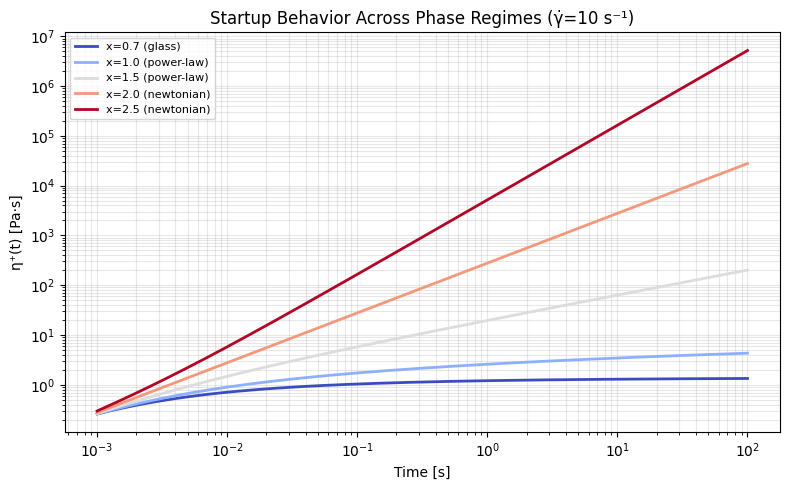

In [8]:
x_values = [0.7, 1.0, 1.5, 2.0, 2.5]
t_sweep = np.logspace(-3, 2, 200)

fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.cm.coolwarm(np.linspace(0, 1, len(x_values)))

for i, x_val in enumerate(x_values):
    m = SGRConventional()
    m.parameters.set_value("x", x_val)
    m.parameters.set_value("G0", 500.0)
    m.parameters.set_value("tau0", 1e-3)
    m.fitted_ = True
    m._test_mode = "startup"
    m._startup_gamma_dot = 10.0

    eta_sweep = m.predict(t_sweep)
    regime = m.get_phase_regime()
    ax.loglog(t_sweep, eta_sweep, "-", color=colors[i], lw=2, label=f"x={x_val} ({regime})")

ax.set_xlabel("Time [s]")
ax.set_ylabel("η⁺(t) [Pa·s]")
ax.set_title("Startup Behavior Across Phase Regimes (γ̇=10 s⁻¹)")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Dynamic Noise Temperature

### 5.1 Thixotropic x(t) Evolution

With `dynamic_x=True`, the noise temperature x evolves under shear according to:

$$
\frac{dx}{dt} = -\alpha_{\text{aging}} \cdot (x - x_{\text{eq}}) + \beta_{\text{rejuv}} \cdot \dot{\gamma} \cdot (x_{\text{ss}} - x)
$$

where:

$$
x_{\text{ss}}(\dot{\gamma}) = x_{\text{eq}} + A \cdot (\dot{\gamma} \cdot \tau_0)^n
$$

This equation couples aging (structural recovery) and rejuvenation (shear-induced breakdown).

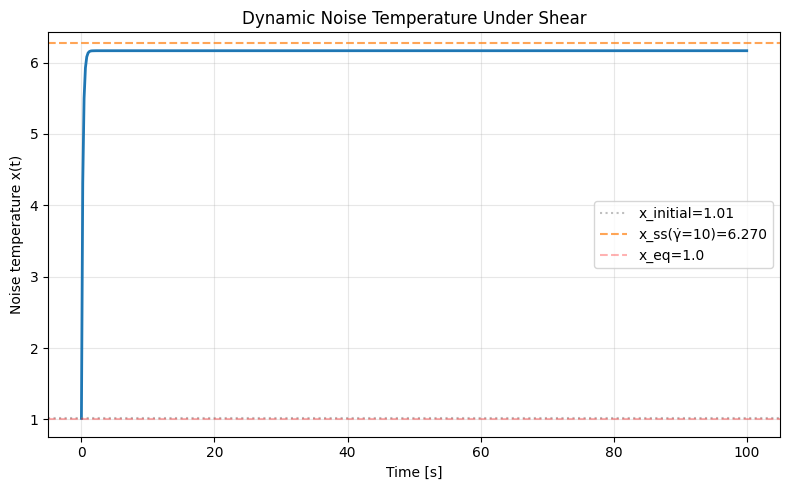

In [9]:
model_dyn = SGRConventional(dynamic_x=True)

# Set parameters
model_dyn.parameters.set_value("x", calib_params["x"])
model_dyn.parameters.set_value("G0", calib_params["G0"])
model_dyn.parameters.set_value("tau0", calib_params["tau0"])
model_dyn.parameters.set_value("x_eq", 1.0)
model_dyn.parameters.set_value("alpha_aging", 0.1)
model_dyn.parameters.set_value("beta_rejuv", 0.5)
model_dyn.parameters.set_value("x_ss_A", 0.5)
model_dyn.parameters.set_value("x_ss_n", 0.3)

# Evolve x under constant shear
t_evol = np.linspace(0, 100, 500)
gamma_dot_evol = np.full_like(t_evol, 10.0)  # Constant shear rate

x_trajectory = model_dyn.evolve_x(t_evol, gamma_dot_evol, x_initial=calib_params["x"])

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t_evol, np.array(x_trajectory), "-", lw=2)
ax.axhline(calib_params["x"], color="gray", linestyle=":", alpha=0.5, label=f"x_initial={calib_params['x']:.2f}")

# Compute x_ss for this shear rate
tau0_val = calib_params["tau0"]
x_ss_val = 1.0 + 0.5 * (10.0 * tau0_val) ** 0.3
ax.axhline(x_ss_val, color="C1", linestyle="--", alpha=0.7, label=f"x_ss(γ̇=10)={x_ss_val:.3f}")
ax.axhline(1.0, color="red", linestyle="--", alpha=0.3, label="x_eq=1.0")

ax.set_xlabel("Time [s]")
ax.set_ylabel("Noise temperature x(t)")
ax.set_title("Dynamic Noise Temperature Under Shear")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

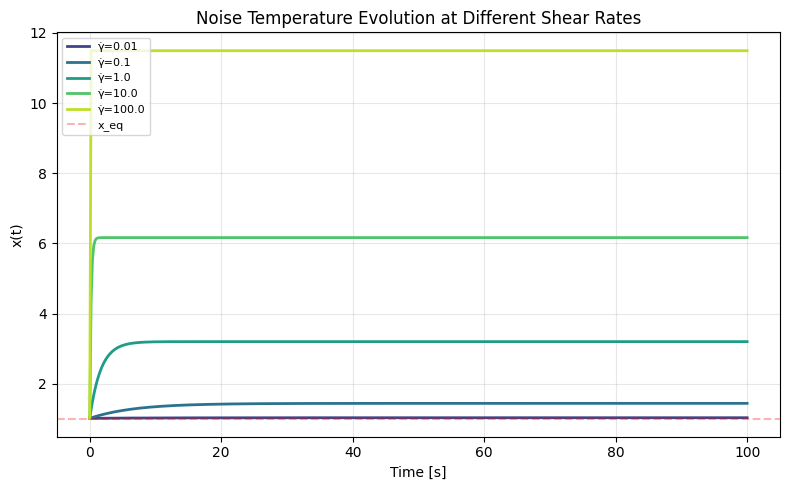

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
gd_values = [0.01, 0.1, 1.0, 10.0, 100.0]
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(gd_values)))

for i, gd in enumerate(gd_values):
    gamma_dot_arr = np.full_like(t_evol, gd)
    x_traj = model_dyn.evolve_x(t_evol, gamma_dot_arr, x_initial=calib_params["x"])
    ax.plot(t_evol, np.array(x_traj), "-", color=colors[i], lw=2, label=f"γ̇={gd}")

ax.axhline(1.0, color="red", linestyle="--", alpha=0.3, label="x_eq")
ax.set_xlabel("Time [s]")
ax.set_ylabel("x(t)")
ax.set_title("Noise Temperature Evolution at Different Shear Rates")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

Higher shear rates drive x further from equilibrium (rejuvenation dominates), while at rest, aging pulls x back toward x_eq. This is the SGR mechanism for thixotropy.

## 6. Bayesian Inference

### 6.1 Run NUTS

**Important**: For startup mode, set `model._startup_gamma_dot` before calling `fit_bayesian()`.

In [11]:
initial_values = {name: model.parameters.get_value(name) for name in ["x", "G0", "tau0"]}
print("Warm-start values:", initial_values)

# Ensure startup gamma_dot is set
model._startup_gamma_dot = gd_fit

NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

t0 = time.time()
result = model.fit_bayesian(
    d["t"], d["eta_plus"], test_mode="startup",
    num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS,
    initial_values=initial_values, seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values: {'x': 0.5010249230229469, 'G0': 26.966705591939245, 'tau0': 341.66439752007784}


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<09:35,  1.21it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   9%|▉         | 64/700 [00:00<00:06, 94.04it/s, 79 steps of size 4.87e-03. acc. prob=0.84]

warmup:  20%|█▉        | 137/700 [00:01<00:02, 204.50it/s, 15 steps of size 6.01e-02. acc. prob=0.87]

warmup:  27%|██▋       | 191/700 [00:01<00:01, 256.83it/s, 255 steps of size 2.55e-02. acc. prob=0.87]

sample:  35%|███▌      | 246/700 [00:01<00:01, 318.27it/s, 59 steps of size 2.18e-02. acc. prob=0.93] 

sample:  43%|████▎     | 303/700 [00:01<00:01, 375.34it/s, 255 steps of size 2.18e-02. acc. prob=0.93]

sample:  51%|█████     | 356/700 [00:01<00:00, 378.23it/s, 255 steps of size 2.18e-02. acc. prob=0.92]

sample:  63%|██████▎   | 442/700 [00:01<00:00, 494.18it/s, 223 steps of size 2.18e-02. acc. prob=0.78]

sample:  73%|███████▎  | 513/700 [00:01<00:00, 542.00it/s, 31 steps of size 2.18e-02. acc. prob=0.73] 

sample:  82%|████████▏ | 575/700 [00:01<00:00, 551.64it/s, 23 steps of size 2.18e-02. acc. prob=0.76]

sample:  91%|█████████ | 636/700 [00:01<00:00, 536.80it/s, 119 steps of size 2.18e-02. acc. prob=0.78]

sample: 100%|█████████▉| 699/700 [00:02<00:00, 561.01it/s, 95 steps of size 2.18e-02. acc. prob=0.80] 

sample: 100%|██████████| 700/700 [00:02<00:00, 344.54it/s, 31 steps of size 2.18e-02. acc. prob=0.80]


Bayesian inference time: 4.4 s


### 6.2 Convergence Diagnostics

In [12]:
diag = result.diagnostics
param_names = ["x", "G0", "tau0"]

print("Convergence Diagnostics")
print("=" * 50)
print(f"{'Parameter':>10s}  {'R-hat':>8s}  {'ESS':>8s}")
print("-" * 50)
for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    print(f"{p:>10s}  {r_hat:8.4f}  {ess:8.0f}")
n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

Convergence Diagnostics
 Parameter     R-hat       ESS
--------------------------------------------------
         x    0.9980        14
        G0    0.9980        14
      tau0    0.9983        14

Divergences: 18


### 6.3 ArviZ Plots

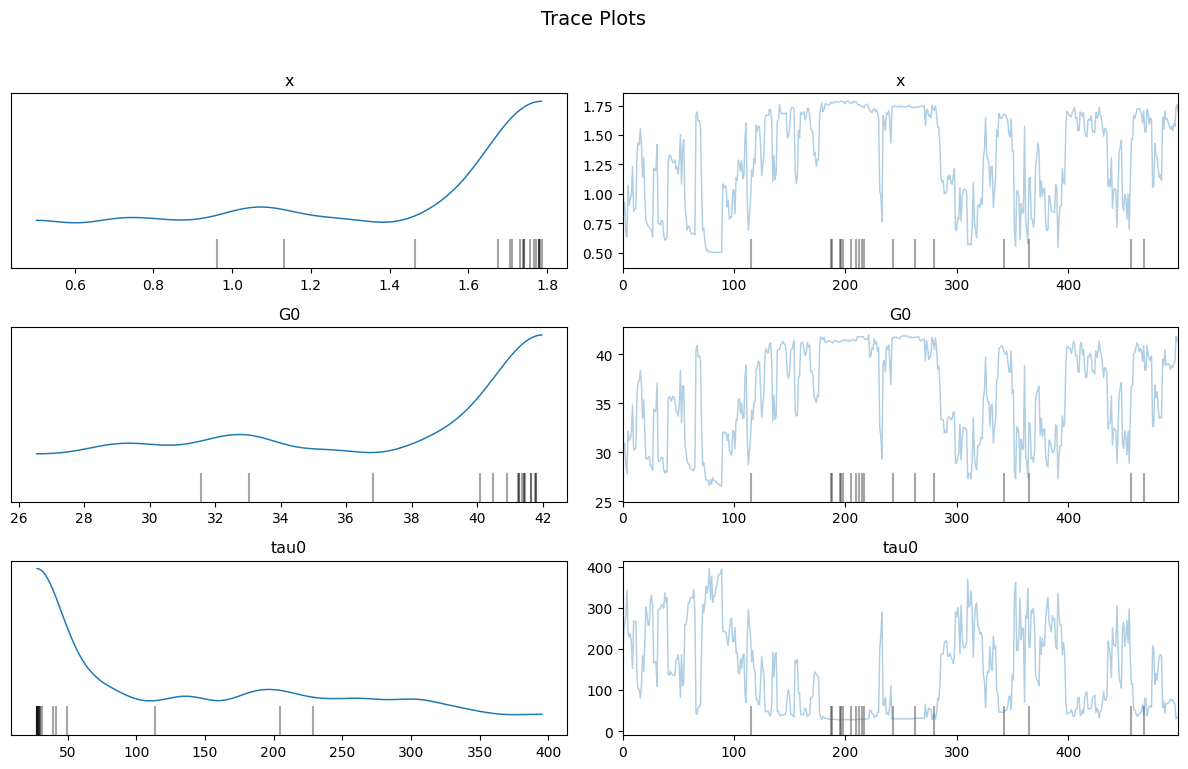

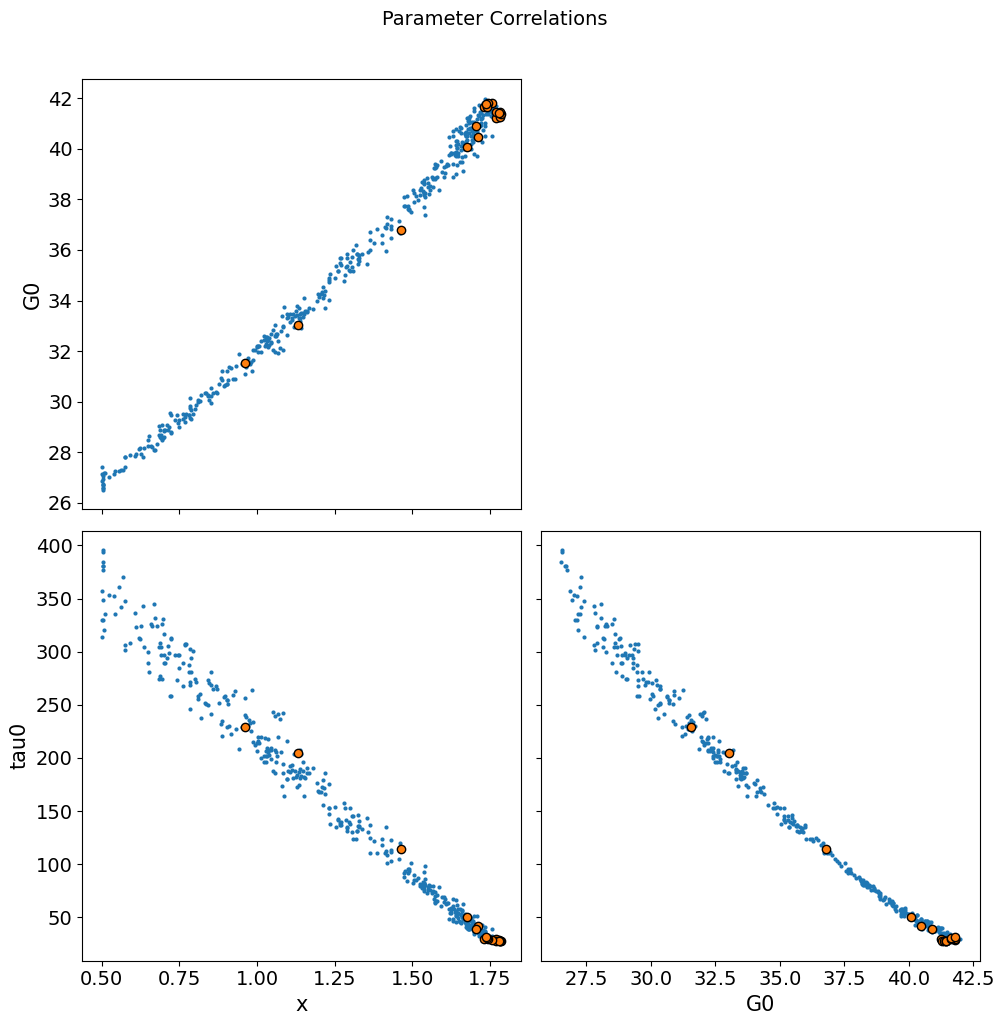

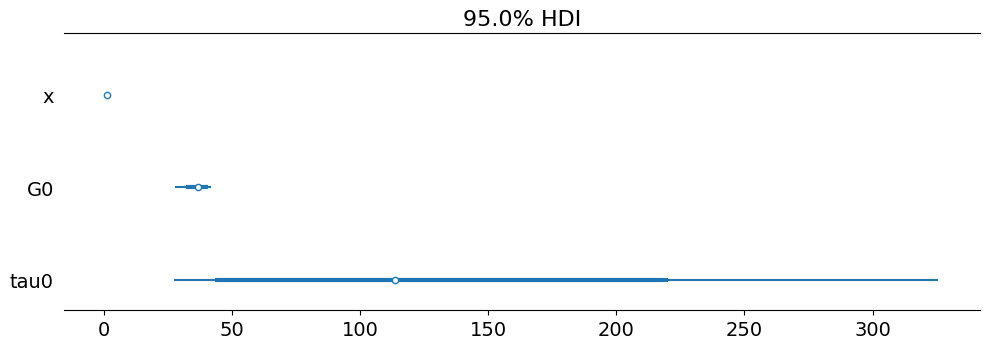

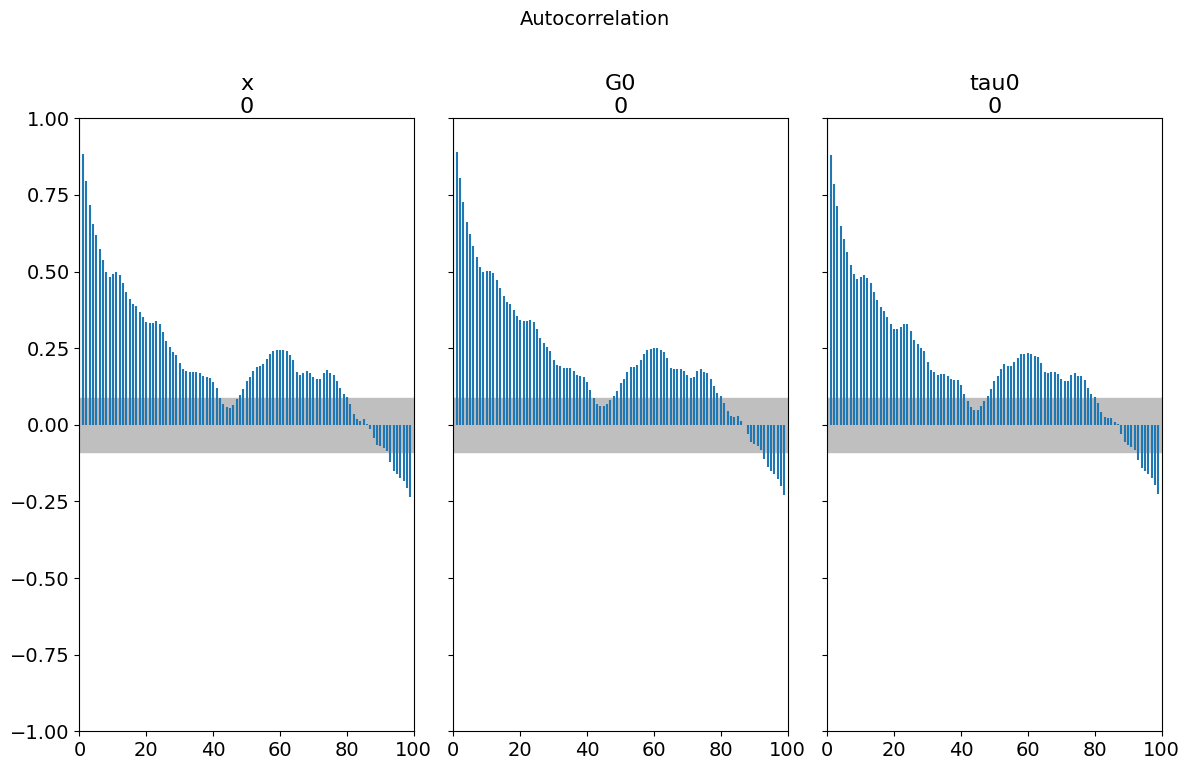

In [13]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorrelation, rank)
param_names = ["x", "G0", "tau0"]
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

### 6.4 Posterior Predictive

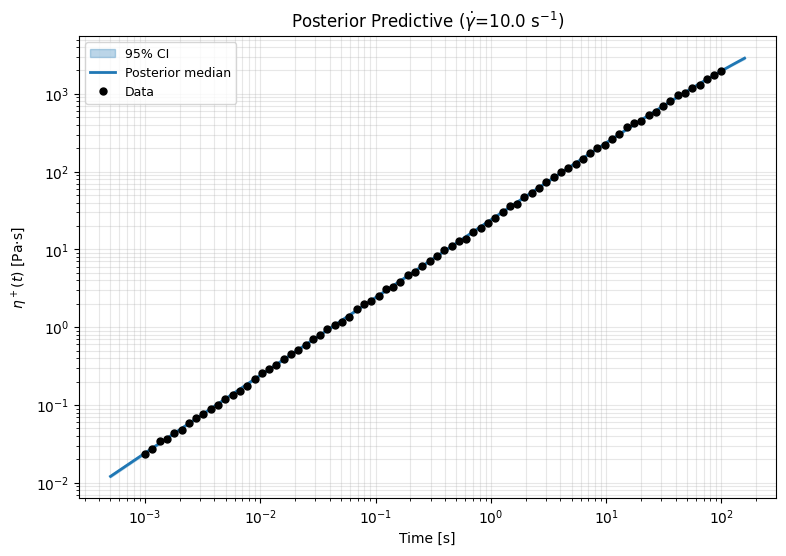

In [14]:
# Posterior predictive with 95% credible intervals
param_names = ["x", "G0", "tau0"]
fig, ax = plot_posterior_predictive(
    d["t"], d["eta_plus"], model, result,
    test_mode="startup", param_names=param_names,
    xlabel="Time [s]", ylabel=r"$\eta^+(t)$ [Pa$\cdot$s]",
    title=f"Posterior Predictive ($\\dot{{\\gamma}}$={gd_fit} s$^{{-1}}$)",
)
display(fig)
plt.close(fig)

## 7. Save Results

In [15]:
output_dir = os.path.join("..", "outputs", "sgr", "startup")
os.makedirs(output_dir, exist_ok=True)

nlsq_params = {name: float(model.parameters.get_value(name)) for name in ["x", "G0", "tau0"]}
with open(os.path.join(output_dir, "nlsq_params.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

# Save posterior samples (if available)
posterior = getattr(result, "posterior_samples", None) if "result" in dir() else None
if posterior is not None:
    posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
    with open(os.path.join(output_dir, "posterior_samples.json"), "w") as f:
        json.dump(posterior_dict, f)

print(f"Results saved to {output_dir}/")


Results saved to ../outputs/sgr/startup/


## Further Reading

- [SGR Conventional Handbook](../../docs/source/models/sgr/sgr_conventional.rst)
- Sollich, P. (1998). Rheological constitutive equation for a model of soft glassy materials. *Phys. Rev. E*, 58, 738–759.
- Fielding, S.M. et al. (2000). Aging and rheology in soft materials. *J. Rheol.*, 44, 323–369.
- Sollich, P. & Cates, M.E. (2012). Thermodynamic interpretation of soft glassy rheology models. *Phys. Rev. E*, 85, 031127.

## Next Steps

- **NB 06**: LAOS — large-amplitude oscillatory shear for nonlinear response
- **NB 01**: Flow curves — steady-state viscosity $\eta \sim \dot{\gamma}^{x-2}$
- Explore multi-shear-rate fitting with simultaneous estimation
- Investigate dynamic_x parameter estimation from startup transients